# Machine Learning: Lasso Regression

Lasso regression is, like ridge regression, a **shrinkage** method. It differs from ridge regression in its choice of penalty: lasso imposes an $\ell_1$ **penalty** on the paramters $\beta$. That is, lasso finds an assignment to $\beta$ that minimizes the function

$$f(\beta) = \|X\beta - Y\|_2^2 + \lambda \|\beta\|_1,$$

where $\lambda$ is a hyperparameter and, as usual, $X$ is the training data and $Y$ the observations. The $\ell_1$ penalty encourages **sparsity** in the learned parameters, and, as we will see, can drive many coefficients to zero. In this sense, lasso is a continuous **feature selection** method.

In this notebook, we show how to fit a lasso model using CVXPY, how to evaluate the model, and how to tune the hyperparameter $\lambda$.


In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

### Writing the objective function

We can decompose the **objective function** as the sum of a **least squares loss function** and an $\ell_1$ **regularizer**.

In [2]:
def loss_fn(X, Y, beta):
    return cp.norm2(cp.matmul(X, beta) - Y)**2

def regularizer(beta):
    return cp.norm1(beta)

def objective_fn(X, Y, beta, lambd):
    return loss_fn(X, Y, beta) + lambd * regularizer(beta)

def mse(X, Y, beta):
    return (1.0 / X.shape[0]) * loss_fn(X, Y, beta).value

### Generating data
We generate training examples and observations that are linearly related; we make the relationship *sparse*, and we'll see how lasso will approximately recover it.

In [3]:
def generate_data(m=100, n=20, sigma=5, density=0.2):
    "Generates data matrix X and observations Y."
    np.random.seed(1)
    beta_star = np.random.randn(n)
    idxs = np.random.choice(range(n), int((1-density)*n), replace=False)
    for idx in idxs:
        beta_star[idx] = 0
    X = np.random.randn(m,n)
    Y = X.dot(beta_star) + np.random.normal(0, sigma, size=m)
    return X, Y, beta_star

m = 100
n = 20
sigma = 5
density = 0.2

X, Y, _ = generate_data(m, n, sigma)
X_train = X[:50, :]
Y_train = Y[:50]
X_test = X[50:, :]
Y_test = Y[50:]

### Fitting the model

All we need to do to fit the model is create a CVXPY problem where the objective is to minimize the objective function defined above. We make $\lambda$ a CVXPY parameter, so that we can use a single CVXPY problem to obtain estimates for many values of $\lambda$.

In [4]:
beta = cp.Variable(n)
lambd = cp.Parameter(nonneg=True)
problem = cp.Problem(cp.Minimize(objective_fn(X_train, Y_train, beta, lambd)))

lambd_values = np.logspace(-2, 3, 50)
train_errors = []
test_errors = []
beta_values = []
for v in lambd_values:
    lambd.value = v
    problem.solve()
    train_errors.append(mse(X_train, Y_train, beta))
    test_errors.append(mse(X_test, Y_test, beta))
    beta_values.append(beta.value)

### Evaluating the model
Just as we saw for ridge regression, regularization improves generalizability.

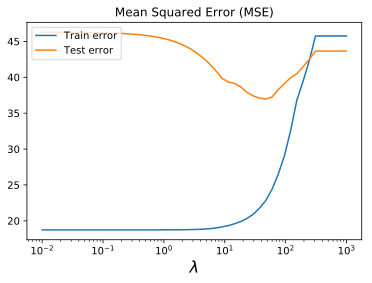

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def plot_train_test_errors(train_errors, test_errors, lambd_values):
    plt.plot(lambd_values, train_errors, label="Train error")
    plt.plot(lambd_values, test_errors, label="Test error")
    plt.xscale("log")
    plt.legend(loc="upper left")
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.title("Mean Squared Error (MSE)")
    plt.show()
    
plot_train_test_errors(train_errors, test_errors, lambd_values)

### Regularization path and feature selection
As $\lambda$ increases, the parameters are driven to $0$. By $\lambda \approx 10$, approximately 80 percent of the coefficients are *exactly* zero. This parallels the fact that $\beta^*$ was generated such that 80 percent of its entries were zero. The features corresponding to the slowest decaying coefficients can be interpreted as the most important ones.

**Qualitatively, lasso differs from ridge in that the former often drives parameters to exactly zero, whereas the latter shrinks parameters but does not usually zero them out. That is, lasso results in sparse models; ridge (usually) does not.**

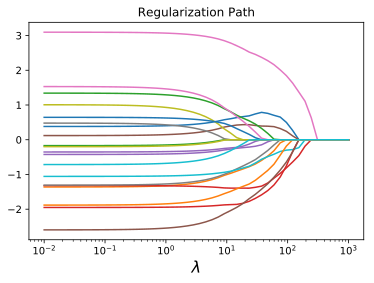

In [6]:
def plot_regularization_path(lambd_values, beta_values):
    num_coeffs = len(beta_values[0])
    for i in range(num_coeffs):
        plt.plot(lambd_values, [wi[i] for wi in beta_values])
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.xscale("log")
    plt.title("Regularization Path")
    plt.show()
    
plot_regularization_path(lambd_values, beta_values)